In [1]:
import pandas as pd
from tqdm import tqdm
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl

%matplotlib inline

## Чтение данных

In [2]:
items = pd.read_csv('items.csv', delimiter=';', dtype={'author': str, 'bbk': str, 'izd': str, 'sys_numb': str, 'title': str, 'year_izd': str})

In [3]:
items.head()

,sys_numb,title,author,izd,year_izd,bbk
0,RSL01008600016,Судебное следствие в уголовном процессе России...,"Машовец, Асия Океановна",Юрлитинформ,2016,"Х629.374,0"
1,RSL01004304880,Уральское казачество и его роль в системе росс...,"Дубовиков, Александр Маратович",none,2006,none
2,RSL07000461043,отсутствует,отсутствует,отсутствует,отсутствует,отсутствует
3,RSL07000433335,отсутствует,отсутствует,отсутствует,отсутствует,отсутствует
4,RSL01002419013,"""Я пишу как эхо другого.."" : Очерки интеллекту...","Щедрина, Татьяна Геннадьевна",Прогресс-Традиция,2004,"Ю3(2)6-69Шпет Г.Г.-3,0"


In [4]:
items[items['title'] == 'отсутствует'].shape

(26676, 6)

In [5]:
items[items['author'].isin(['отсутствует', 'none'])].shape

(91730, 6)

In [6]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354355 entries, 0 to 354354
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sys_numb  354355 non-null  object
 1   title     354355 non-null  object
 2   author    354355 non-null  object
 3   izd       354355 non-null  object
 4   year_izd  354354 non-null  object
 5   bbk       354281 non-null  object
dtypes: object(6)
memory usage: 16.2+ MB


In [7]:
users = pd.read_csv('users.csv', delimiter=';', dtype={'age': str, 'chb': str, 'chit_type': str, 'gender': str})

In [8]:
users.head()

,chb,age,gender,chit_type
0,300001020830,21,female,нет данных
1,300001113642,36,female,нет данных
2,300001148466,46,female,нет данных
3,300001117011,22,female,нет данных
4,200001038094,24,female,echb


In [9]:
users['gender'].value_counts()

female         10407
male            6332
не указан         13
отсутствует        1
Name: gender, dtype: int64

In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16753 entries, 0 to 16752
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   chb        16753 non-null  object
 1   age        16753 non-null  object
 2   gender     16753 non-null  object
 3   chit_type  16753 non-null  object
dtypes: object(4)
memory usage: 523.7+ KB


In [11]:
transactions = pd.read_csv('train_transactions_extended.csv', delimiter=';', dtype={'chb': str, 'date_1': str, 'is_printed': str, 'is_real': str, 'source': str, 'sys_numb': str, 'type': str})

In [12]:
transactions.head()

,chb,sys_numb,date_1,is_real,type,source,is_printed
0,100000641403,RSL01004206702,2021-02-21,yes,скачивание,dlib.rsl.ru,False
1,100000641403,RSL01000769304,2021-03-23,yes,скачивание,dlib.rsl.ru,False
2,100000641403,RSL01004211574,2021-02-21,yes,скачивание,dlib.rsl.ru,False
3,100000644359,RSL01009800093,2021-03-16,yes,книговыдача,единый просмоторщик,False
4,100000644359,RSL01003557352,2021-03-10,yes,книговыдача,единый просмоторщик,False


In [13]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259566 entries, 0 to 259565
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   chb         259566 non-null  object
 1   sys_numb    259566 non-null  object
 2   date_1      259566 non-null  object
 3   is_real     259566 non-null  object
 4   type        259566 non-null  object
 5   source      259566 non-null  object
 6   is_printed  259566 non-null  object
dtypes: object(7)
memory usage: 13.9+ MB


In [14]:
transactions['type'].value_counts()

None           141372
книговыдача     85809
скачивание      32015
скачка            370
Name: type, dtype: int64

In [15]:
transactions['is_real'].value_counts()

yes    247928
no      11638
Name: is_real, dtype: int64

In [16]:
n_users = len(transactions['chb'].unique())
n_items = len(items['sys_numb'].unique())

mapping_chb_index = {chb_number: index for index, chb_number in enumerate(transactions['chb'].unique())}
mapping_sys_numb_index = {sys_number: index for index, sys_number in enumerate(items['sys_numb'].unique())}

mapping_index_chb = {index: chb_number for index, chb_number in enumerate(transactions['chb'].unique())}
mapping_index_sys_numb = {index: sys_number for index, sys_number in enumerate(items['sys_numb'].unique())}

In [17]:
users_filtered = users[users['gender'].isin({'male', 'female'}) & users['age'].apply(lambda x: x.isdigit())]

In [18]:
users_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16739 entries, 0 to 16752
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   chb        16739 non-null  object
 1   age        16739 non-null  object
 2   gender     16739 non-null  object
 3   chit_type  16739 non-null  object
dtypes: object(4)
memory usage: 653.9+ KB


### бьём на train и test

In [19]:
train_data, test_data = train_test_split(transactions)

### Готовим данные для рекомендаций на основе социальных данных (пола и возраста)

In [19]:
train_users = set(train_data['chb'])

In [20]:
soc_stat = pd.DataFrame(users_filtered.merge(train_data, on='chb').groupby(['age', 'gender'])['sys_numb'].value_counts().sort_values(ascending=False))
soc_stat.columns = ['cnt']
soc_stat.reset_index(inplace=True)
soc_stat_top5 = soc_stat.groupby(['age', 'gender']).head(5)

In [21]:
recommendations_by_soc = {(age, gender): [] for age in range(5, 100) for gender in ['male', 'female']}

for age in range(5, 100):
    for gender in ['male', 'female']:
        gender_slice = soc_stat_top5[soc_stat_top5['gender'] == gender]
        gender_slice['age_diff'] = np.abs(gender_slice['age'].astype(int) - age)
        min_diff = gender_slice['age_diff'].min()
        soc_scice = gender_slice[gender_slice['age_diff'] == min_diff]
        recommendations_by_soc[(age, gender)] = soc_scice['sys_numb'].values[0:5]
        

C:\Users\Brux\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Модель

Мы используем ALS из baseline решения с некоторыми улучшениями:

1) Новому пользователю будем рекомендовать топ-5 самых популярных книг на основе социальных данных пользователя (пола и возраста)

2) Мы устанавливаем минимальное пороговое значение для скора, которое найдём, максимизируя f1-метрику

In [60]:
def df_to_sparse(df):
    row = []
    col = []
    data = []

    for line in df.itertuples():
        row.append(mapping_chb_index[line.chb])
        col.append(mapping_sys_numb_index[line.sys_numb])
        data.append(1)

    return csr_matrix((data, (row, col)))

In [61]:
train_data_sparse = df_to_sparse(train_data)
test_data_sparse = df_to_sparse(test_data)

In [62]:
model = AlternatingLeastSquares()
model.fit(train_data_sparse)

C:\Users\Brux\anaconda3\lib\site-packages\implicit\utils.py:27: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


In [25]:
def get_recom(userid, n=30, min_score=0):
    reccomendations = []
    scores = []
    if mapping_index_chb[userid] not in train_users:
        try:
            user = users[users['chb'] == mapping_index_sys_numb[userid]].iloc[0]
            age, gender = user['age'], user['gender']
            if (age, gender) in recommendations_by_soc:
                reccomendations = recommendations_by_soc[(age, gender)]
                scores = [10 for x in reccomendations]
        except:
            pass
    else:
        ids, scores = model.recommend(userid, train_data_sparse[userid], N=n, filter_already_liked_items=False)
        reccomendations = [mapping_index_sys_numb[id] for id in ids]
    
    recom_df = pd.DataFrame({"sys_numb": reccomendations, "score": scores})
    return recom_df[recom_df['score'] >= min_score]

In [26]:
all_rec = []

for userid in tqdm(range(train_data_sparse.shape[0]), position=0, leave=True):
    user_chb = mapping_index_chb[userid]
    user_rec = get_recom(userid)
    for rn, row in user_rec.iterrows():
        all_rec.append([user_chb, row['sys_numb'], row['score']])

100%|███████████████████████████████████████████████████████████████████████████| 16753/16753 [02:21<00:00, 118.48it/s]


In [27]:
solution = pd.DataFrame(all_rec, columns=["chb", "sys_numb", "score"])

посмотрим как распределён скор

In [28]:
solution['score'].mean(), solution['score'].median()

(0.008475257806516676, 7.062298664095579e-06)

In [29]:
score_quantiles = np.quantile(solution['score'], np.arange(0, 1, 0.01))

## Считаем метрики

In [45]:
def metric(df_solution, df_grd):
    pred = set(df_solution['chb'].astype(str) + '_' + df_solution['sys_numb'].values)
    true = set(df_grd['chb'].astype(str) + '_' + df_grd['sys_numb'].values)
    recall = len(pred.intersection(true)) / len(true)
    precision = len(pred.intersection(true)) / (len(df_solution[df_solution['chb'].isin(df_grd['chb'])]))
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score, precision, recall

In [31]:
f1_scores, precisions, recalls = [], [], []

for quant in score_quantiles:
    df_solution = solution[solution['score'] >= quant]
    f1, prec, rec = metric(df_solution, test_data)
    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(rec)

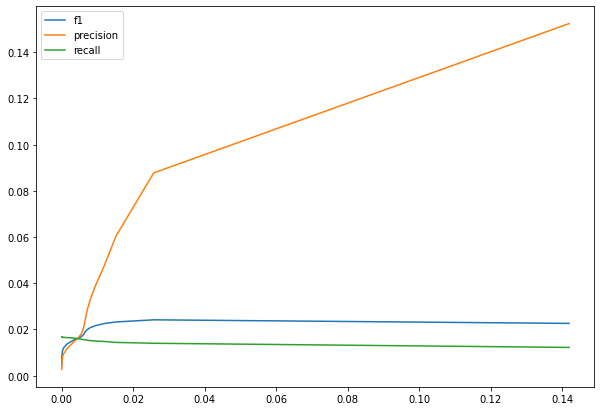

In [32]:
plt.figure(figsize=(10, 7))
plt.plot(score_quantiles, f1_scores, label='f1')
plt.plot(score_quantiles, precisions, label='precision')
plt.plot(score_quantiles, recalls, label='recall')
plt.legend()
plt.show()

Видим, что точность растёт при увеличении ограничений на скор рекомендуемой книги, полнота падает, как и должно быть. Выберем отсечку исходя из f1 метрики

In [33]:
threshold = np.argmax(f1_scores)

In [34]:
best_solution = solution[solution['score'] >= score_quantiles[threshold]]

In [39]:
metrics = metric(best_solution, test_data)
print(f"f1: {metrics[0]}")
print(f"precision: {metrics[1]}")
print(f"recall: {metrics[2]}")

f1: 0.024167174768582676
precision: 0.08777934366821019
recall: 0.014012534147517275


Видим что по сравнению с бейзлайном, полнота слегка уменьшилась, однако точность улучшилась в 27 раз, f1 более чем в 4 раза

In [ ]:
best_solution.drop("score", axis=1).to_csv("solution.csv", index=False, sep=';')

## Doc2Vec

Векторизуем тексты, если текст близок к хотя бы одному тексту который читает пользователь -- добавляем его в рекомендации, из таких берём топ 3

In [52]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 
from collections import namedtuple

векторизуем лишь те где есть заголовок

In [40]:
items_with_title = items[items['title'] != 'отсутствует']

In [145]:
items_with_title.head()

,sys_numb,title,author,izd,year_izd,bbk
0,RSL01008600016,Судебное следствие в уголовном процессе России...,"Машовец, Асия Океановна",Юрлитинформ,2016,"Х629.374,0"
1,RSL01004304880,Уральское казачество и его роль в системе росс...,"Дубовиков, Александр Маратович",none,2006,none
4,RSL01002419013,"""Я пишу как эхо другого.."" : Очерки интеллекту...","Щедрина, Татьяна Геннадьевна",Прогресс-Традиция,2004,"Ю3(2)6-69Шпет Г.Г.-3,0"
5,RSL01004307424,Использование дробных физических нагрузок в ст...,"Статун, Алла Николаевна",none,2007,none
7,RSL01009483558,Очерк психологии полиморфной индивидуальности ...,"Белоус, Валерий Владимирович",none,2016,none


технические штуки: отображения id книги в номер строки и обратно

In [147]:
id2ind = {el: i for i, el in enumerate(items_with_title['sys_numb'])}
ind2id = {i: el for i, el in enumerate(items_with_title['sys_numb'])}

обучаем doc2vec

In [47]:
def get_words(doc):
    words = doc.lower().split()
    words = list(map(lambda x: "".join(filter(lambda l: l.isalpha(), x)), words))
    return list(filter(lambda x: len(x) > 0, words))

In [53]:
titles = list(map(get_words, items_with_title['title']))

In [54]:
Documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(titles)]

In [55]:
model = doc2vec.Doc2Vec(Documents)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
docvecs = np.array([model.docvecs[i] for i in range(len(titles))])

для каждой книги ищем 4 самые похожие

In [122]:
similar_docs = []
batch_size = 1000

for i in tqdm(range(0, len(titles), batch_size), leave=True, position=0):
    cos = cosine_similarity(docvecs[i:i+batch_size], docvecs)
    inds = np.argpartition(cos, -4, axis=1)[:,-4:]
    for k in range(len(inds)):
        similar_docs.append([(j, cos[k][j]) for j in inds[k] if i != j])

100%|████████████████████████████████████████████████████████████████████████████████| 328/328 [22:37<00:00,  4.14s/it]


среди них оказывается и сама эта книга так что ее фильтруем, отстается 3

In [141]:
similar_docs = list(map(lambda x: list(filter(lambda y: y[1] < 0.9999, x)), similar_docs))

считаются предыдущие блоки довольно долго, поэтому сохраним их результат на диск

In [142]:
import pickle as pkl

with open('similar_docs.pkl', 'wb') as f:
    pkl.dump(similar_docs, f)

In [7]:
with open('similar_docs.pkl', 'rb') as f:
    similar_docs = pkl.loads(f.read())

In [8]:
similar_docs[0:5]

[[(87270, 0.9109883), (309490, 0.9154674), (186650, 0.9183717)],
 [(84397, 0.7826655), (15748, 0.78635573), (121615, 0.79929936)],
 [(296927, 0.8650393), (272036, 0.8684506), (321468, 0.8659157)],
 [(84175, 0.63082457), (117980, 0.6323839), (6269, 0.6482941)],
 [(105403, 0.81315696), (164461, 0.8181336), (247354, 0.8307483)]]

пример похожих книг, первое число -- индекс книги, второе -- похожесть

In [143]:
similar_docs[2]

[(296927, 0.8650393), (272036, 0.8684506), (321468, 0.8659157)]

функция рекомендации. Берём топ n (по умолчанию 3) книги, которые больше всего похожи на какую нибудь которую скачивал пользователь. Убираем из них те, что он уже скачивал

In [198]:
def reccomend_by_d2v(user_id, n=3):
    fav_items = set(train_data[train_data['chb'] == user_id]['sys_numb'])

    rec_items = []
    for item in fav_items:
        if item in id2ind:
            rec_items += similar_docs[id2ind[item]]
    result = []

    rec_items = sorted(rec_items, key=lambda x: -x[1])[0:n]
    for item in rec_items:
        result.append(ind2id[item[0]])

    return list(set(result) - fav_items)

пример

In [199]:
reccomend_by_d2v('300000990687')

['RSL01004905282', 'RSL01009399349', 'RSL01003157641']

In [210]:
d2v_reccomendations = []

for userid in tqdm(range(train_data_sparse.shape[0]), position=0, leave=True):
    user_chb = mapping_index_chb[userid]
    user_rec = reccomend_by_d2v(user_chb)
    for rec in user_rec:
        d2v_reccomendations.append([user_chb, rec])

100%|████████████████████████████████████████████████████████████████████████████| 16753/16753 [03:10<00:00, 87.96it/s]


получаем решение на основе doc2vec, добавляем его к нашему предыдущему SVD решению

In [214]:
d2v_solution = pd.DataFrame(d2v_reccomendations, columns=["chb", "sys_numb"])

In [215]:
solution_with_d2v = pd.concat([best_solution, d2v_solution])

In [216]:
metrics = metric(solution_with_d2v, test_data)
print(f"f1: {metrics[0]}")
print(f"precision: {metrics[1]}")
print(f"recall: {metrics[2]}")

f1: 0.018895847245032397
precision: 0.02154853050135836
recall: 0.016824682628957095


Подняли немного recall, но сильно ухудшили precision, тем не менее решение теперь по всем метрикам лучше baseline

In [217]:
solution_with_d2v.to_csv("solution_withd2v.csv", index=False, sep=';')

## Добавление рекомендаций по авторам

In [21]:
items_with_author = items[~items['author'].isin(['отсутствует', 'none'])].dropna(subset=['author'])

In [22]:
items_with_author['author'].value_counts()

Конволют                                                    937
Зверев, Сергей Иванович 1964-                               323
Струнников, Сергей Николаевич 1907-1944                     227
Россия. Законы и постановления                              226
Серова, Марина Сергеевна                                    199
                                                           ... 
Костоусов, Алексей Геннадьевич                                1
Володченкова, Оксана Юрьевна                                  1
Орлов, Анатолий Петрович 1879-1937                            1
Ибраев, Марат Умербаевич                                      1
D. Baazov museum of history of Jews of Georgia (Tbilisi)      1
Name: author, Length: 172620, dtype: int64

In [127]:
items_with_author.head()

,sys_numb,title,author,izd,year_izd,bbk
0,RSL01008600016,Судебное следствие в уголовном процессе России...,"Машовец, Асия Океановна",Юрлитинформ,2016,"Х629.374,0"
1,RSL01004304880,Уральское казачество и его роль в системе росс...,"Дубовиков, Александр Маратович",none,2006,none
4,RSL01002419013,"""Я пишу как эхо другого.."" : Очерки интеллекту...","Щедрина, Татьяна Геннадьевна",Прогресс-Традиция,2004,"Ю3(2)6-69Шпет Г.Г.-3,0"
5,RSL01004307424,Использование дробных физических нагрузок в ст...,"Статун, Алла Николаевна",none,2007,none
7,RSL01009483558,Очерк психологии полиморфной индивидуальности ...,"Белоус, Валерий Владимирович",none,2016,none


In [29]:
train_data_with_auth = train_data.merge(items_with_author, on=['sys_numb'], how='inner')

In [30]:
train_data_with_auth.shape

(142982, 12)

In [31]:
n_users = len(transactions['chb'].unique())
n_items = len(items_with_author['author'].unique())

mapping_chb_index = {chb_number: index for index, chb_number in enumerate(transactions['chb'].unique())}
mapping_sys_numb_index = {sys_number: index for index, sys_number in enumerate(items_with_author['author'].unique())}

mapping_index_chb = {index: chb_number for index, chb_number in enumerate(transactions['chb'].unique())}
mapping_index_sys_numb = {index: sys_number for index, sys_number in enumerate(items_with_author['author'].unique())}

In [32]:
def df_to_sparse(df):
    row = []
    col = []
    data = []

    for line in df.itertuples():
        row.append(mapping_chb_index[line.chb])
        col.append(mapping_sys_numb_index[line.author])
        data.append(1)

    return csr_matrix((data, (row, col)))

In [33]:
train_data_sparse = df_to_sparse(train_data_with_auth)
test_data_sparse = df_to_sparse(train_data_with_auth)

In [34]:
model = AlternatingLeastSquares()
model.fit(train_data_sparse)

C:\Users\Brux\anaconda3\lib\site-packages\implicit\utils.py:27: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


In [23]:
author2items = {}

for gn, group in items_with_author.groupby('author'):
    author2items[gn] = set(group['sys_numb'])

In [24]:
user2item = {}

for gn, group in train_data.groupby('chb'):
    user2item[gn] = set(group['sys_numb'])

In [38]:
def get_recom_auth(userid, n_auth=2, n_items=2, min_score=0):
    reccomendations = []
    scores = []
    ids, scores = model.recommend(userid, train_data_sparse[userid], N=n_auth, filter_already_liked_items=False)
    reccomendations = [mapping_index_sys_numb[id] for id in ids]
    
    items_reccomendations = []
    for i in range(len(reccomendations)):
        if scores[i] >= min_score and mapping_index_chb[userid] in user2item:
            items_reccomendations += list(author2items[reccomendations[i]] - user2item[mapping_index_chb[userid]])[0:n_items]

    return items_reccomendations

In [39]:
auth_rec = []

for userid in tqdm(range(train_data_sparse.shape[0]), position=0, leave=True):
    user_chb = mapping_index_chb[userid]
    user_rec = get_recom_auth(userid)
    for rec in user_rec:
        auth_rec.append([user_chb, rec])

100%|███████████████████████████████████████████████████████████████████████████| 16753/16753 [00:47<00:00, 353.12it/s]


In [40]:
solution_auth = pd.DataFrame(auth_rec, columns=["chb", "sys_numb"])

In [41]:
solution_auth

,chb,sys_numb
0,100000641403,RSL01003627421
1,100000641403,RSL01010999862
2,100000641403,RSL01005577940
3,100000641403,RSL01005577852
4,100000644359,RSL01005048336
...,...,...
63653,300001173062,RSL01001795305
63654,400001035059,RSL01004020232
63655,400001035059,RSL01005421445
63656,400001035059,RSL01003767865


In [86]:
solution_with_d2v = pd.read_csv("solution_withd2v.csv", sep=';')

In [87]:
solution_with_d2v_and_auth = pd.concat([solution_with_d2v, solution_auth]).drop_duplicates()

In [88]:
metrics = metric(solution_with_d2v_and_auth, test_data)
print(f"f1: {metrics[0]}")
print(f"precision: {metrics[1]}")
print(f"recall: {metrics[2]}")


f1: 0.03610818280874888
precision: 0.040265539178883314
recall: 0.032728966259294355


In [97]:
solution_with_d2v_and_auth.groupby(by='chb').head(20).drop('score', axis=1).astype(str).to_csv("solution_withd2v_authors.csv", index=False, sep=';')

In [98]:
solution = pd.read_csv('solution_withd2v_authors.csv', delimiter=';')

In [99]:
solution.shape

(118527, 2)

In [100]:
solution['chb'].value_counts()

100000704313    24
200001131427    24
300000840426    24
300000823942    24
300000821615    24
                ..
300000871957     2
300000873973     2
300000890992     2
200000865887     2
200001123324     2
Name: chb, Length: 16742, dtype: int64

In [95]:
solution

,chb,sys_numb
0,100000704313,RSL01003921476
1,100000704313,RSL01003921447
2,100000704313,RSL01003921463
3,100000704313,RSL01003821761
4,100000704313,RSL01003647118
...,...,...
118522,300001173062,RSL01001795305
118523,400001035059,RSL01004020232
118524,400001035059,RSL01005421445
118525,400001035059,RSL01003767865


In [115]:
solution_with_d2v_and_auth.dropna(subset=['chb'])

,chb,sys_numb,score
0,100000704313,RSL01003921476,1.071200
1,100000704313,RSL01003921447,1.047348
2,100000704313,RSL01003921463,1.040125
3,100000704313,RSL01003821761,1.039680
4,100000704313,RSL01003647118,1.036009
...,...,...,...
63653,300001173062,RSL01001795305,NaN
63654,400001035059,RSL01004020232,NaN
63655,400001035059,RSL01005421445,NaN
63656,400001035059,RSL01003767865,NaN


In [117]:
solution_with_d2v_and_auth['chb'] = solution_with_d2v_and_auth['chb'].apply(lambda x: str(x).strip())

In [118]:
solution_with_d2v_and_auth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122521 entries, 0 to 63657
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   chb       122521 non-null  object 
 1   sys_numb  122521 non-null  object 
 2   score     9967 non-null    float64
dtypes: float64(1), object(2)
memory usage: 3.7+ MB


In [119]:
solution = solution_with_d2v_and_auth.groupby(by='chb').head(20).drop('score', axis=1)

In [120]:
solution['chb'].value_counts()

100000704313    20
300000840633    20
300000867560    20
300000863416    20
300000862221    20
                ..
300000871957     2
300000873973     2
300000890992     2
200000865887     2
200001123324     2
Name: chb, Length: 16742, dtype: int64

In [121]:
solution.shape

(117402, 2)

In [105]:
solution.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118527 entries, 0 to 63657
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   chb       118527 non-null  object
 1   sys_numb  118527 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [122]:
solution.to_csv('final_solution.csv', index=False, sep=';')

In [123]:
pd.read_csv('final_solution.csv', sep=';')['chb'].value_counts()

100000704313    20
300000840633    20
300000867560    20
300000863416    20
300000862221    20
                ..
300000871957     2
300000873973     2
300000890992     2
200000865887     2
200001123324     2
Name: chb, Length: 16742, dtype: int64

## Простая рекомендация при помощи авторов

In [43]:
train_data['is_real'].value_counts()

yes    185958
no       8716
Name: is_real, dtype: int64

In [145]:
user2item_df = []
for user in user2item:
    for item in user2item[user]:
        user2item_df.append([user, item])

user2item_df = pd.DataFrame(user2item_df, columns=['chb', 'sys_numb'])

In [146]:
user2author_df = pd.DataFrame(user2item_df.merge(items, on=['sys_numb']).groupby('chb')['author'].value_counts())
user2author_df.columns = ['count']
user2author_df = user2author_df.reset_index()

In [147]:
user2author_df

,chb,author,count
0,100000641403,"Максимов, Владимир Лаврович",2
1,100000641403,"Шалаев, Николай Федорович",1
2,100000644359,"Акылбеков, Нургали Икрамович",1
3,100000644359,"Барат, Вера Александровна",1
4,100000644359,"Борисова, Полина Николаевна",1
...,...,...,...
131710,300001173062,"Грицаев, Сергей Анатольевич",1
131711,300001173062,"Марусин, Игорь Станиславович",1
131712,400001035059,"Зауторова, Эльвира Викторовна",1
131713,400001035059,"Чугунова, Ирина Владимировна",1


In [148]:
user2author_df = user2author_df.merge(items_with_author, on='author').merge(train_data, on=['chb', 'sys_numb'], how='left')

In [149]:
user2author_df = user2author_df[user2author_df['is_real'].isna()]

In [150]:
user2author_df.sort_values(by='count', ascending=False, inplace=True)

In [153]:
user2author_df.sort_values(by=['count'], ascending=False, inplace=True)

In [154]:
user2author_df.groupby('chb').head(20)[['chb', 'sys_numb']].to_csv('simple_sol_auth.csv', index=False, sep=';')

In [93]:
pd.read_csv('simple_sol_auth.csv', sep=';')['chb'].value_counts()

300001044845    10
300000938156    10
300000841505    10
300001072099    10
200001068380    10
                ..
200001068035     1
200001069823     1
300001151920     1
200000976281     1
200000793485     1
Name: chb, Length: 11818, dtype: int64